In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model

In [3]:
df_WADI = pd.read_csv("Data_Sets/WADI_14days_new.csv")

In [81]:
# not needed, only if we want to put time stamps
# Time_Stamp_925 = pd.date_range(start='2017-09-25 18:00:00', periods = 21600, freq='s')
#Time_Stamp_926 = pd.date_range(start='2017-09-26 00:00:00', periods = 86400, freq='s')
#Time_Stamp_927 = pd.date_range(start='2017-09-27 00:00:00', periods = 86400, freq='s')
#Time_Stamp_928 = pd.date_range(start='2017-09-28 00:00:00', periods = 86400, freq='s')
#Time_Stamp_929 = pd.date_range(start='2017-09-29 00:00:00', periods = 55199, freq='s')
#Time_Stamp_102 = pd.date_range(start='2017-10-02 16:39:00', periods = 26401, freq='s')
#Time_Stamp_103 = pd.date_range(start='2017-10-03 00:00:00', periods = 86400, freq='s')
#Time_Stamp_104 = pd.date_range(start='2017-10-04 00:00:00', periods = 86400, freq='s')
#Time_Stamp_105 = pd.date_range(start='2017-10-05 00:00:00', periods = 86400, freq='s')
#Time_Stamp_106 = pd.date_range(start='2017-10-06 00:00:00', periods = 86400, freq='s')
#Time_Stamp_107 = pd.date_range(start='2017-10-07 00:00:00', periods = 76571, freq='s')

In [96]:
#append time stamps and add to new column for time series
# Time_Stamp_14 = Time_Stamp_925.append(Time_Stamp_926).append(Time_Stamp_927).append(Time_Stamp_928).append(Time_Stamp_929).append(Time_Stamp_102).append(Time_Stamp_103).append(Time_Stamp_104).append(Time_Stamp_105).append(Time_Stamp_106).append(Time_Stamp_107)
#df_WADI['Time_Stamp'] = Time_Stamp_14

In [4]:
df_WADIi = pd.read_csv("Data_sets/WADI_attackdataLABLE.csv", header = 1)

In [5]:
df_WADIi_a = df_WADIi.iloc[:-2] # remove last two rows as they have NaN time stamp
Time_Stamp = pd.date_range(start='2017-10-09 18:00:00', periods = 172801, freq='s') # create time frame starting from 10/09 1800 to 10/11 1800 (2days)
df_WADIi_a['Time_Stamp'] = Time_Stamp # add new column with time stamp

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#remove rows from original WADI that only have 1 unique value
for col in df_WADIi_a.columns:
    if df_WADIi_a[col].nunique() == 1:
        df_WADIi_a.drop(col, inplace=True, axis=1)

#remove rows from original WADI that have 0 values
for col in df_WADIi_a.columns:
    if df_WADIi_a[col].nunique() == 0:
        df_WADIi_a.drop(col, inplace=True, axis=1)

df_WADIi_a.shape

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(172801, 101)

In [7]:
# use clean WADI to train and attack WADI to test
train = df_WADI[['Row', '2_PIT_002_PV']]

In [8]:
#add Row column for no real purpose but just to have x axis labels
num = range(0, 784571)
df_WADI['Row'] = num

<AxesSubplot:xlabel='Row'>

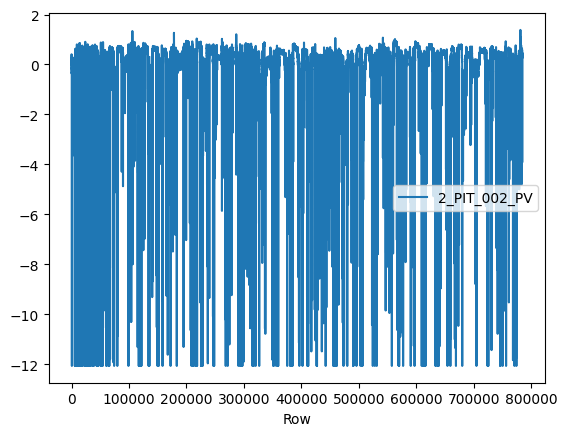

In [128]:
train.plot('Row', '2_PIT_002_PV')

In [9]:
train_mean = train['2_PIT_002_PV'].mean()
train_std = train['2_PIT_002_PV'].std()
train['2_PIT_002_PV'] = (train['2_PIT_002_PV']-train_mean)/train_std

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# define the number of points to go back
# function that uses sequences to creat x and y arrays

seq_size = 600 #anything too large will not result in enough memory for processing

def to_sequences(x, y, seq_size = 1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

In [11]:
trainX, trainY = to_sequences(train[['2_PIT_002_PV']], train[['2_PIT_002_PV']], seq_size)

In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(4, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer = 'adam',loss = 'mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 repeat_vector (RepeatVector  (None, 600, 4)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 600, 4)            144       
                                                                 
 dropout_1 (Dropout)         (None, 600, 4)            0         
                                                                 
 time_distributed (TimeDistr  (None, 600, 1)           5         
 ibuted)                                                

In [13]:
history = model.fit(trainX, trainY, epochs=1, batch_size=120, validation_split=0.1, verbose=True)

5880/5880 [==============================] - 1622s 275ms/step - loss: 0.1532 - val_loss: 0.0841


In [14]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis = 1)

24500/24500 [==============================] - 1298s 53ms/step


(array([5.24655e+05, 1.78310e+05, 4.47910e+04, 1.56540e+04, 7.61400e+03,
        2.73100e+03, 1.24700e+03, 8.33000e+02, 7.26000e+02, 7.15000e+02,
        4.77000e+02, 4.01000e+02, 2.96000e+02, 2.51000e+02, 2.32000e+02,
        2.33000e+02, 2.08000e+02, 1.81000e+02, 1.31000e+02, 1.32000e+02,
        1.67000e+02, 1.24000e+02, 1.81000e+02, 2.40000e+02, 4.54000e+02,
        6.34000e+02, 1.22300e+03, 8.33000e+02, 2.47000e+02, 5.00000e+01]),
 array([0.01412305, 0.3061716 , 0.59822014, 0.89026868, 1.18231722,
        1.47436576, 1.7664143 , 2.05846285, 2.35051139, 2.64255993,
        2.93460847, 3.22665701, 3.51870555, 3.81075409, 4.10280264,
        4.39485118, 4.68689972, 4.97894826, 5.2709968 , 5.56304534,
        5.85509389, 6.14714243, 6.43919097, 6.73123951, 7.02328805,
        7.31533659, 7.60738513, 7.89943368, 8.19148222, 8.48353076,
        8.7755793 ]),
 <BarContainer object of 30 artists>)

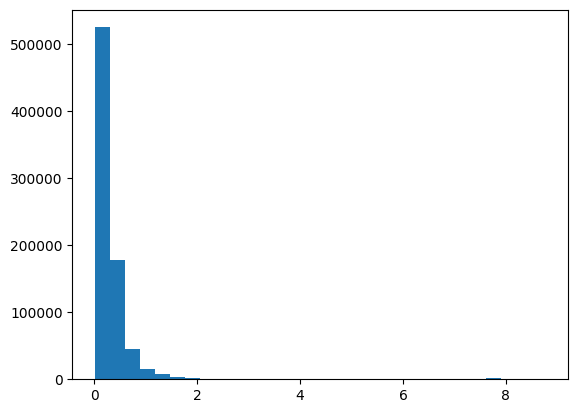

In [15]:
plt.hist(trainMAE, bins=30)

In [18]:
test = df_WADIi[['Row ','2_PIT_002_PV']]

In [24]:
test_mean = test['2_PIT_002_PV'].mean()
test_std = test['2_PIT_002_PV'].std()
test['2_PIT_002_PV'] = (test['2_PIT_002_PV']-test_mean)/test_std

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
testX, testY = to_sequences(test[['2_PIT_002_PV']], test[['2_PIT_002_PV']], seq_size)

5382/5382 [==============================] - 246s 46ms/step


(array([1.17738e+05, 3.53210e+04, 9.09500e+03, 4.05900e+03, 1.28500e+03,
        9.00000e+02, 7.96000e+02, 5.36000e+02, 4.03000e+02, 2.81000e+02,
        2.26000e+02, 2.08000e+02, 7.40000e+01, 9.10000e+01, 5.40000e+01,
        5.80000e+01, 4.80000e+01, 3.40000e+01, 2.30000e+01, 3.10000e+01,
        1.40000e+01, 4.80000e+01, 5.40000e+01, 1.20000e+02, 1.12000e+02,
        4.80000e+01, 1.28000e+02, 1.87000e+02, 1.59000e+02, 7.10000e+01]),
 array([0.01313019, 0.29197129, 0.57081239, 0.8496535 , 1.1284946 ,
        1.40733571, 1.68617681, 1.96501791, 2.24385902, 2.52270012,
        2.80154123, 3.08038233, 3.35922343, 3.63806454, 3.91690564,
        4.19574675, 4.47458785, 4.75342895, 5.03227006, 5.31111116,
        5.58995226, 5.86879337, 6.14763447, 6.42647558, 6.70531668,
        6.98415778, 7.26299889, 7.54183999, 7.8206811 , 8.0995222 ,
        8.3783633 ]),
 <BarContainer object of 30 artists>)

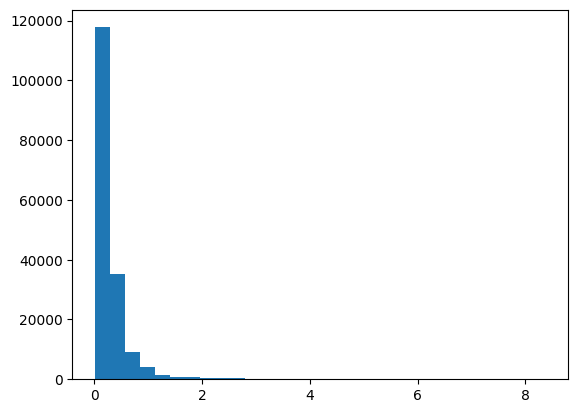

In [41]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis =1)
plt.hist(testMAE, bins=30)

In [51]:
max_trainMAE = 7

In [52]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomalies = anomaly_df.loc[anomaly_df['anomaly']==True]

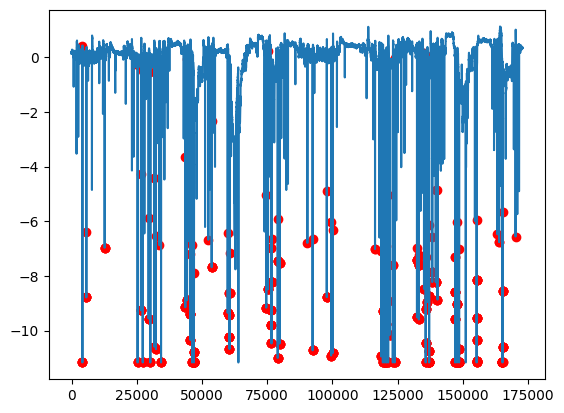

In [65]:
plt.scatter(anomalies['Row '], anomalies['2_PIT_002_PV'], color = 'r')
plt.plot(test['Row '], test['2_PIT_002_PV'])
plt.show()

In [78]:
#reduce training to three day by truncating original 14 day file
train_red = train.iloc[0:round(df_WADI.shape[0]/3),]

In [80]:
seq_size_red = 2000
train_redX, train_redY = to_sequences(train_red[['2_PIT_002_PV']], train_red[['2_PIT_002_PV']], seq_size_red)

In [81]:
model_r = Sequential()
model_r.add(LSTM(4, input_shape=(train_redX.shape[1], train_redX.shape[2])))
model_r.add(Dropout(rate=0.2))

model_r.add(RepeatVector(train_redX.shape[1]))

model_r.add(LSTM(4, return_sequences=True))
model_r.add(Dropout(rate=0.2))
model_r.add(TimeDistributed(Dense(train_redX.shape[2])))
model_r.compile(optimizer = 'adam',loss = 'mae')
model_r.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 96        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 2000, 4)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 2000, 4)           144       
                                                                 
 dropout_3 (Dropout)         (None, 2000, 4)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 2000, 1)          5         
 tributed)                                            

In [82]:
history_red = model_r.fit(train_redX, train_redY, epochs=1, batch_size=120, validation_split=0.1, verbose=True)

1947/1947 [==============================] - 3108s 2s/step - loss: 0.1834 - val_loss: 0.1296


In [83]:
trainPredict_r = model_r.predict(train_redX)
trainMAE_r = np.mean(np.abs(trainPredict_r - train_redX), axis = 1)

8111/8111 [==============================] - 2651s 327ms/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_8111_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[259524,2000,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ConcatV2] name: concat

In [ ]:
#  Misc code below

In [66]:
test.head()

,Row,2_PIT_002_PV
0,1.0,0.127836
1,2.0,0.127836
2,3.0,0.127836
3,4.0,0.127836
4,5.0,0.127836


In [80]:
Dates = df_WADI['Date'].unique()
len(Dates)

11

In [79]:
for date in Dates:
    print(date)
    print(sum(df_WADI['Date']== date))

9/25/2017
21600
9/26/2017
86400
9/27/2017
86400
9/28/2017
86400
9/29/2017
55199
10/2/17
26401
10/3/17
86400
10/4/17
86400
10/5/17
86400
10/6/17
86400
10/7/17
76571


In [60]:
df_WADI.tail()

,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Time_Stamp
784566,1048567,10/7/17,16:06.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,...,1,1,1,1,1,1,60.6305,1,0.25,2017-10-04 19:56:06
784567,1048568,10/7/17,16:07.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,...,1,1,1,1,1,1,60.6305,1,0.25,2017-10-04 19:56:07
784568,1048569,10/7/17,16:08.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,...,1,1,1,1,1,1,60.6305,1,0.25,2017-10-04 19:56:08
784569,1048570,10/7/17,16:09.0,175.896,0.613476,11.8913,479.224,0.331622,0.001173,0,...,1,1,1,1,1,1,60.4477,1,0.25,2017-10-04 19:56:09
784570,1048571,10/7/17,16:10.0,175.896,0.613476,11.8913,479.224,0.331622,0.001173,0,...,1,1,1,1,1,1,60.4477,1,0.25,2017-10-04 19:56:10


In [23]:
PIT2_a = PIT2[PIT2['Attack LABLE (1:No Attack, -1:Attack)']==-1]
PIT2_a.head()

,Time_Stamp,2_PIT_002_PV,"Attack LABLE (1:No Attack, -1:Attack)"
5103,2017-10-09 19:25:03,90.1949,-1
5104,2017-10-09 19:25:04,90.1949,-1
5105,2017-10-09 19:25:05,90.1949,-1
5106,2017-10-09 19:25:06,90.1703,-1
5107,2017-10-09 19:25:07,90.1703,-1


<AxesSubplot:xlabel='Time_Stamp'>

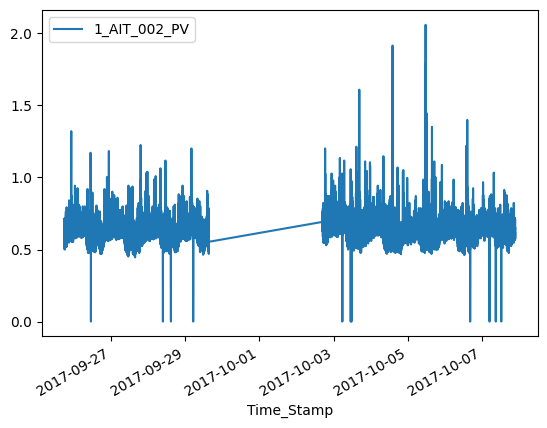

In [100]:
df_WADI.plot('Time_Stamp', '1_AIT_002_PV')
#PIT2.plot('Time_Stamp', '2_PIT_002_PV')

<AxesSubplot:xlabel='Time_Stamp'>

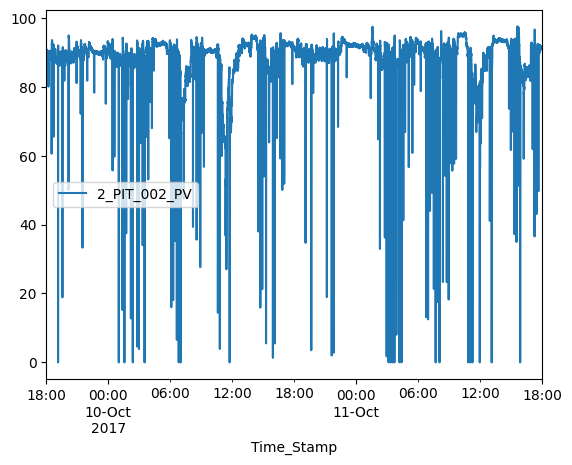

In [28]:
df_WADIi_a.plot('Time_Stamp', '2_PIT_002_PV')

<AxesSubplot:xlabel='Time_Stamp'>

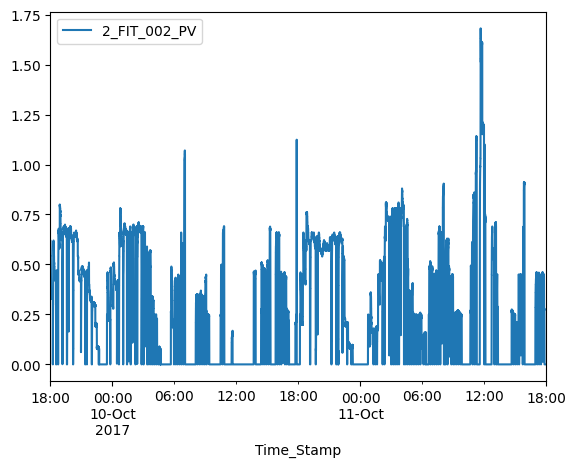

In [18]:
df_WADIi_a.plot('Time_Stamp','2_FIT_002_PV')